### ***EDA BASADO EN EL MACHINE LEARNING***

###### **Filtramos los datos**

In [1]:
# Importamos librerias 
import mysql.connector
from mysql.connector import Error
from sqlalchemy import create_engine
import pandas as pd
import os 
import env

In [2]:
# credenciales del AWS

HOST_DB = env.DB_HOST
USER_DB = env.DB_USER
PASS_DB = env.DB_PASS
NAME_DB = env.DB_NAME

In [3]:
# Funcion para conectarse a la base de datos

def BD_connection(host, user_db, user_pass, name_db):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user_db,
            passwd=user_pass,
            database=name_db,
            port=3306,
            connection_timeout=300
        )
        print("MYSQL DATABASE connection succesful")
    except Error as err:
        print(f"Error: '{err}'")
    return connection

In [4]:
# Nos conectamos a la base de datos 
connection = BD_connection(HOST_DB, USER_DB, PASS_DB, NAME_DB)

MYSQL DATABASE connection succesful


In [5]:
# verifiquemos la conexion realizando una consulta simple
if connection:
    cursor = connection.cursor()
    cursor.execute("SELECT DATABASE()")
    db = cursor.fetchone()
    print(f"Conectado a la base de datos: {db[0]}")

Conectado a la base de datos: UrbanTransit


In [6]:
# Funcion para obtener las tablas disponibles
def show_tables(connection):
    cursor = connection.cursor()
    cursor.execute("SHOW TABLES")
    tables = cursor.fetchall()
    for table in tables:
        print(table)

In [7]:
# Corremos la query
connection = BD_connection(HOST_DB, USER_DB, PASS_DB, NAME_DB)
show_tables(connection)

MYSQL DATABASE connection succesful
('carga_registros',)
('enriched_taxi_data1',)
('enriched_taxi_data2',)
('taxi_fhv_data',)
('taxi_fhv_data1',)
('taxi_zones',)
('temperaturas',)
('trafico',)


In [8]:
# Crear el engine de SQLAlchemy usando la conexion MySQL
def create_sqlalchemy_engine(host_name, user_bd, password_bd, name_bd):
    url = f"mysql+mysqlconnector://{user_bd}:{password_bd}@{host_name}/{name_bd}"
    return create_engine(url)

In [9]:
# Creamos el engine
engine = create_sqlalchemy_engine(HOST_DB, USER_DB, PASS_DB, NAME_DB)

In [10]:
# Consultar SQL para obtener la tabla 'users_review' y 'sites'
query_data0 = "SELECT * FROM taxi_zones;"
query_data1 = "SELECT * FROM taxi_fhv_data WHERE pickup_datetime BETWEEN '2023-01-01' AND '2024-08-31' ORDER BY id"

In [11]:
# Cargamos los datos en un Dataframe
taxi_zone = pd.read_sql(query_data0, engine)
taxi_green = pd.read_sql(query_data1, engine)

In [12]:
# Creamos un punto de reinicio
df_taxi_zone = pd.DataFrame(taxi_zone)
df_taxi_green = pd.DataFrame(taxi_green)

### Comenzamos con el EDA -- (EXPLORATORY DATA ANALYSIS) -- 

**¿En qué consiste el EDA?**
-   Consiste en investigar y comprender los datos mediante técnicas visuales y estadísticas para descubrir patrones, identificar anomalías, probar hipótesis y extraer información útil.
-  El EDA ayuda a los científicos de datos y analistas a obtener una comprensión inicial de los datos antes de aplicar modelos predictivos o análisis más avanzados.

## 1. ***Conociemiento del negocio*** 

### ***Contexto***

---------------------------------------
##### Nuestra empresa Green Route Solutions busca analizar patrones de viajes y zonas en Nueva York para identificar la mejor estrategia para implementar taxis ambientalmente amigables, considerando tanto la rentabilidad como la sostenibilidad.

**Preguntas**
>
>
> **1.Datos** <div>
> 1. ¿Qué variables están presentes en cada dataset? 
> 2. ¿Qué tipos de datos contiene cada columna?  
> 3. ¿Cuántos valores faltantes y duplicados hay por columna en cada dataset? 
> 4. ¿Hay Valores faltantes?
> 5. ¿Hay columnas anidadas? </div>
>  
> **2.Analisís Temporal** <div>
> 1. ¿Cuál es la distribución temporal de los viajes (por meses, días y horas)? </div>
> 
> **3. Analisís de Patrones de Movilidad** <div>
> 1. ¿Cuáles son las zonas con mayor número de viajes de inicio y destino 
> 2. ¿Cuáles son las distancias promedio por viaje y cómo varían según la zona o el borough? 
> 3. ¿Cuál es el tiempo promedio de los viajes y cómo se distribuyen durante el día?</div>
> 
> **4. Analísis de Financiero** <div>
> 1.  ¿Cuál es el ingreso promedio por viaje para los conductores? 
> 2. ¿Qué zonas son más rentables para los conductores y cómo se correlacionan con la cantidad de viajes?
> 3. ¿Existen diferencias significativas en los ingresos entre los diferentes boroughs? </div>
>
>
> ***Las preguntas pueden cambiar***

## 2. ***Carga de Datos*** 

In [15]:
df_taxi_green.head(4)

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,VendorID,source,trip_time
0,1,2024-01-01 00:46:55,2024-01-01 00:58:25,236,239,1.98,21.66,2,G,690
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,65,170,6.54,42.66,2,G,1252
2,3,2024-01-01 00:30:21,2024-01-01 00:49:23,74,262,3.08,28.05,2,G,1142
3,4,2024-01-01 00:30:20,2024-01-01 00:42:12,74,116,2.40,16.70,1,G,712


In [16]:
df_taxi_zone.head(4)

,LocationID,Borough,Zone,the_geom
0,1,EWR,Newark Airport,MULTIPOLYGON (((-74.18445299999996 40.69499599...
1,2,Queens,Jamaica Bay,MULTIPOLYGON (((-73.82337597260663 40.63898704...
2,3,Bronx,Allerton/Pelham Gardens,MULTIPOLYGON (((-73.84792614099985 40.87134223...
3,4,Manhattan,Alphabet City,MULTIPOLYGON (((-73.97177410965318 40.72582128...


### 2.1 Análisis inicial de los datos

In [17]:
# Tamaño de los datos 
print("Tamaño de nuestros datos en df_taxi_green", df_taxi_green.shape)
print("Tamaño de nuestros datos en df_taxi_zones", df_taxi_zone.shape)

Tamaño de nuestros datos en df_taxi_green (1228937, 10)
Tamaño de nuestros datos en df_taxi_zones (261, 4)


In [18]:
# Veamos el tipo de datos que tenemos
df_taxi_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228937 entries, 0 to 1228936
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   id                1228937 non-null  int64         
 1   Pickup_datetime   1228937 non-null  datetime64[ns]
 2   DropOff_datetime  1228937 non-null  datetime64[ns]
 3   PULocationID      1228937 non-null  int64         
 4   DOLocationID      1228937 non-null  int64         
 5   trip_miles        1228937 non-null  float64       
 6   driver_pay        1228937 non-null  float64       
 7   VendorID          1228937 non-null  object        
 8   source            1228937 non-null  object        
 9   trip_time         1228937 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 93.8+ MB


In [19]:
df_taxi_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   LocationID  261 non-null    int64 
 1   Borough     261 non-null    object
 2   Zone        261 non-null    object
 3   the_geom    261 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.3+ KB


In [20]:
# vamos a crear funciones para saber cuantos duplicados, faltantes tenemos en los conjuntos de datos
def null(df, decimales=2):
    # cantidad de null + % 
    df_nulos = pd.DataFrame({
        "Numeros de nulos" : df.isnull().sum(),
        "Porcentaje de nulos" : (df.isnull().sum() / df.shape[0]) * 100.0 # # Calcula el porcentaje de valores faltantes en la columna
    })
    # Convierte el porcentaje a cadena y añade el símbolo de porcentaje
    df_nulos['Porcentaje de nulos'] = df_nulos['Porcentaje de nulos'].round(decimales).astype(str) + "%"
    return df_nulos


def suma_duplicados(df, decimales=2):
    # Identifica las filas duplicadas
    duplicados = df[df.duplicated()]
    
    # Inicializa diccionarios para almacenar los resultados
    num_duplicados = {}
    porcentaje_duplicados = {}
    
    for col in df.columns:
        # Cuenta el número de duplicados en la columna
        num_duplicados[col] = duplicados[col].count()
        
        # Calcula el porcentaje de duplicados en la columna
        porcentaje_duplicados[col] = (num_duplicados[col] / df.shape[0]) * 100.0
    
    # Crea un DataFrame para los resultados
    df_duplicados = pd.DataFrame({
        "Numero de Duplicados": pd.Series(num_duplicados),
        "Porcentaje de Duplicados": pd.Series(porcentaje_duplicados)
    })
    
    # Convierte el porcentaje a cadena y añade el símbolo de porcentaje
    df_duplicados["Porcentaje de Duplicados"] = df_duplicados["Porcentaje de Duplicados"].round(decimales).astype(str) + "%"
        
    return df_duplicados

In [22]:
null(df_taxi_green)

,Numeros de nulos,Porcentaje de nulos
id,0,0.0%
Pickup_datetime,0,0.0%
DropOff_datetime,0,0.0%
PULocationID,0,0.0%
DOLocationID,0,0.0%
trip_miles,0,0.0%
driver_pay,0,0.0%
VendorID,0,0.0%
source,0,0.0%
trip_time,0,0.0%


In [23]:
suma_duplicados(df_taxi_green)

,Numero de Duplicados,Porcentaje de Duplicados
id,0,0.0%
Pickup_datetime,0,0.0%
DropOff_datetime,0,0.0%
PULocationID,0,0.0%
DOLocationID,0,0.0%
trip_miles,0,0.0%
driver_pay,0,0.0%
VendorID,0,0.0%
source,0,0.0%
trip_time,0,0.0%


In [24]:
null(df_taxi_zone)

,Numeros de nulos,Porcentaje de nulos
LocationID,0,0.0%
Borough,0,0.0%
Zone,0,0.0%
the_geom,0,0.0%


In [25]:
suma_duplicados(df_taxi_zone)

,Numero de Duplicados,Porcentaje de Duplicados
LocationID,0,0.0%
Borough,0,0.0%
Zone,0,0.0%
the_geom,0,0.0%


#### **Observaciones del Dataset `df_taxis_green`**

1. **Tamaño del Dataset:**
   - El dataset contiene **1.2 millones de filas** y **10 columnas**.

2. **Tipos de Datos:**
   - Las columnas incluyen una variedad de tipos de datos:
     - **Numéricas:** 4 columnas.
     - **Decimales:** 2 columnas.
     - **Texto (Object):** 2 columnas.
     - **Fechas:** 2 columnas.

3. **Estructura:**
   - Las columnas de tipo fecha representan eventos clave como el inicio (`Pickup_datetime`) y el fin (`DropOff_datetime`) de los viajes.
   - Las columnas numéricas y decimales incluyen métricas relevantes como la distancia (`trip_miles`) y el pago al conductor (`driver_pay`).

4. **Duplicados y faltantes**
   - Es de mi agrado comunicar que no tenemos faltantes, ni dupulicados, ni columnas anidadas

  

In [26]:
df_taxi_green.head(4)

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,VendorID,source,trip_time
0,1,2024-01-01 00:46:55,2024-01-01 00:58:25,236,239,1.98,21.66,2,G,690
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,65,170,6.54,42.66,2,G,1252
2,3,2024-01-01 00:30:21,2024-01-01 00:49:23,74,262,3.08,28.05,2,G,1142
3,4,2024-01-01 00:30:20,2024-01-01 00:42:12,74,116,2.40,16.70,1,G,712


### **Observaciones del Dataset `df_taxis_zones`**

1. **Tamaño del Dataset:**
   - El dataset contiene **261 filas** y **4 columnas**.

2. **Tipos de Datos:**
   - Las columnas incluyen los siguientes tipos de datos:
     - **Numérica:** 1 columna.
     - **Texto (Object):** 3 columnas.

3. **Estructura:**
   - La columna numérica (`LocationID`) identifica de manera única cada zona.
   - Las columnas de texto (`Borough`, `Zone`, `the_geom`) describen el distrito, la zona y la geometría respectiva de cada ubicación.


In [27]:
df_taxi_zone.head(4)

,LocationID,Borough,Zone,the_geom
0,1,EWR,Newark Airport,MULTIPOLYGON (((-74.18445299999996 40.69499599...
1,2,Queens,Jamaica Bay,MULTIPOLYGON (((-73.82337597260663 40.63898704...
2,3,Bronx,Allerton/Pelham Gardens,MULTIPOLYGON (((-73.84792614099985 40.87134223...
3,4,Manhattan,Alphabet City,MULTIPOLYGON (((-73.97177410965318 40.72582128...


## 3. ***Exploración General***

In [36]:
std_taxis = df_taxi_green[['trip_miles', 'trip_time', 'driver_pay']]
std_taxis.describe()

,trip_miles,trip_time,driver_pay
count,1.228937e+06,1.228937e+06,1.228937e+06
mean,1.823741e+01,1.163003e+03,2.386643e+01
std,1.018510e+03,4.645839e+03,1.983473e+01
min,0.000000e+00,0.000000e+00,-5.010000e+02
25%,1.140000e+00,4.510000e+02,1.360000e+01
50%,1.900000e+00,7.140000e+02,1.900000e+01
75%,3.390000e+00,1.108000e+03,2.802000e+01
max,2.789900e+05,8.639500e+04,4.004500e+03


In [37]:
# cambiamos el formato para mejor visualizacion
pd.options.display.float_format = '{:,.2f}'.format

std_taxis.describe()

,trip_miles,trip_time,driver_pay
count,"1,228,937.00","1,228,937.00","1,228,937.00"
mean,18.24,"1,163.00",23.87
std,"1,018.51","4,645.84",19.83
min,0.00,0.00,-501.00
25%,1.14,451.00,13.60
50%,1.90,714.00,19.00
75%,3.39,"1,108.00",28.02
max,"278,990.00","86,395.00","4,004.50"


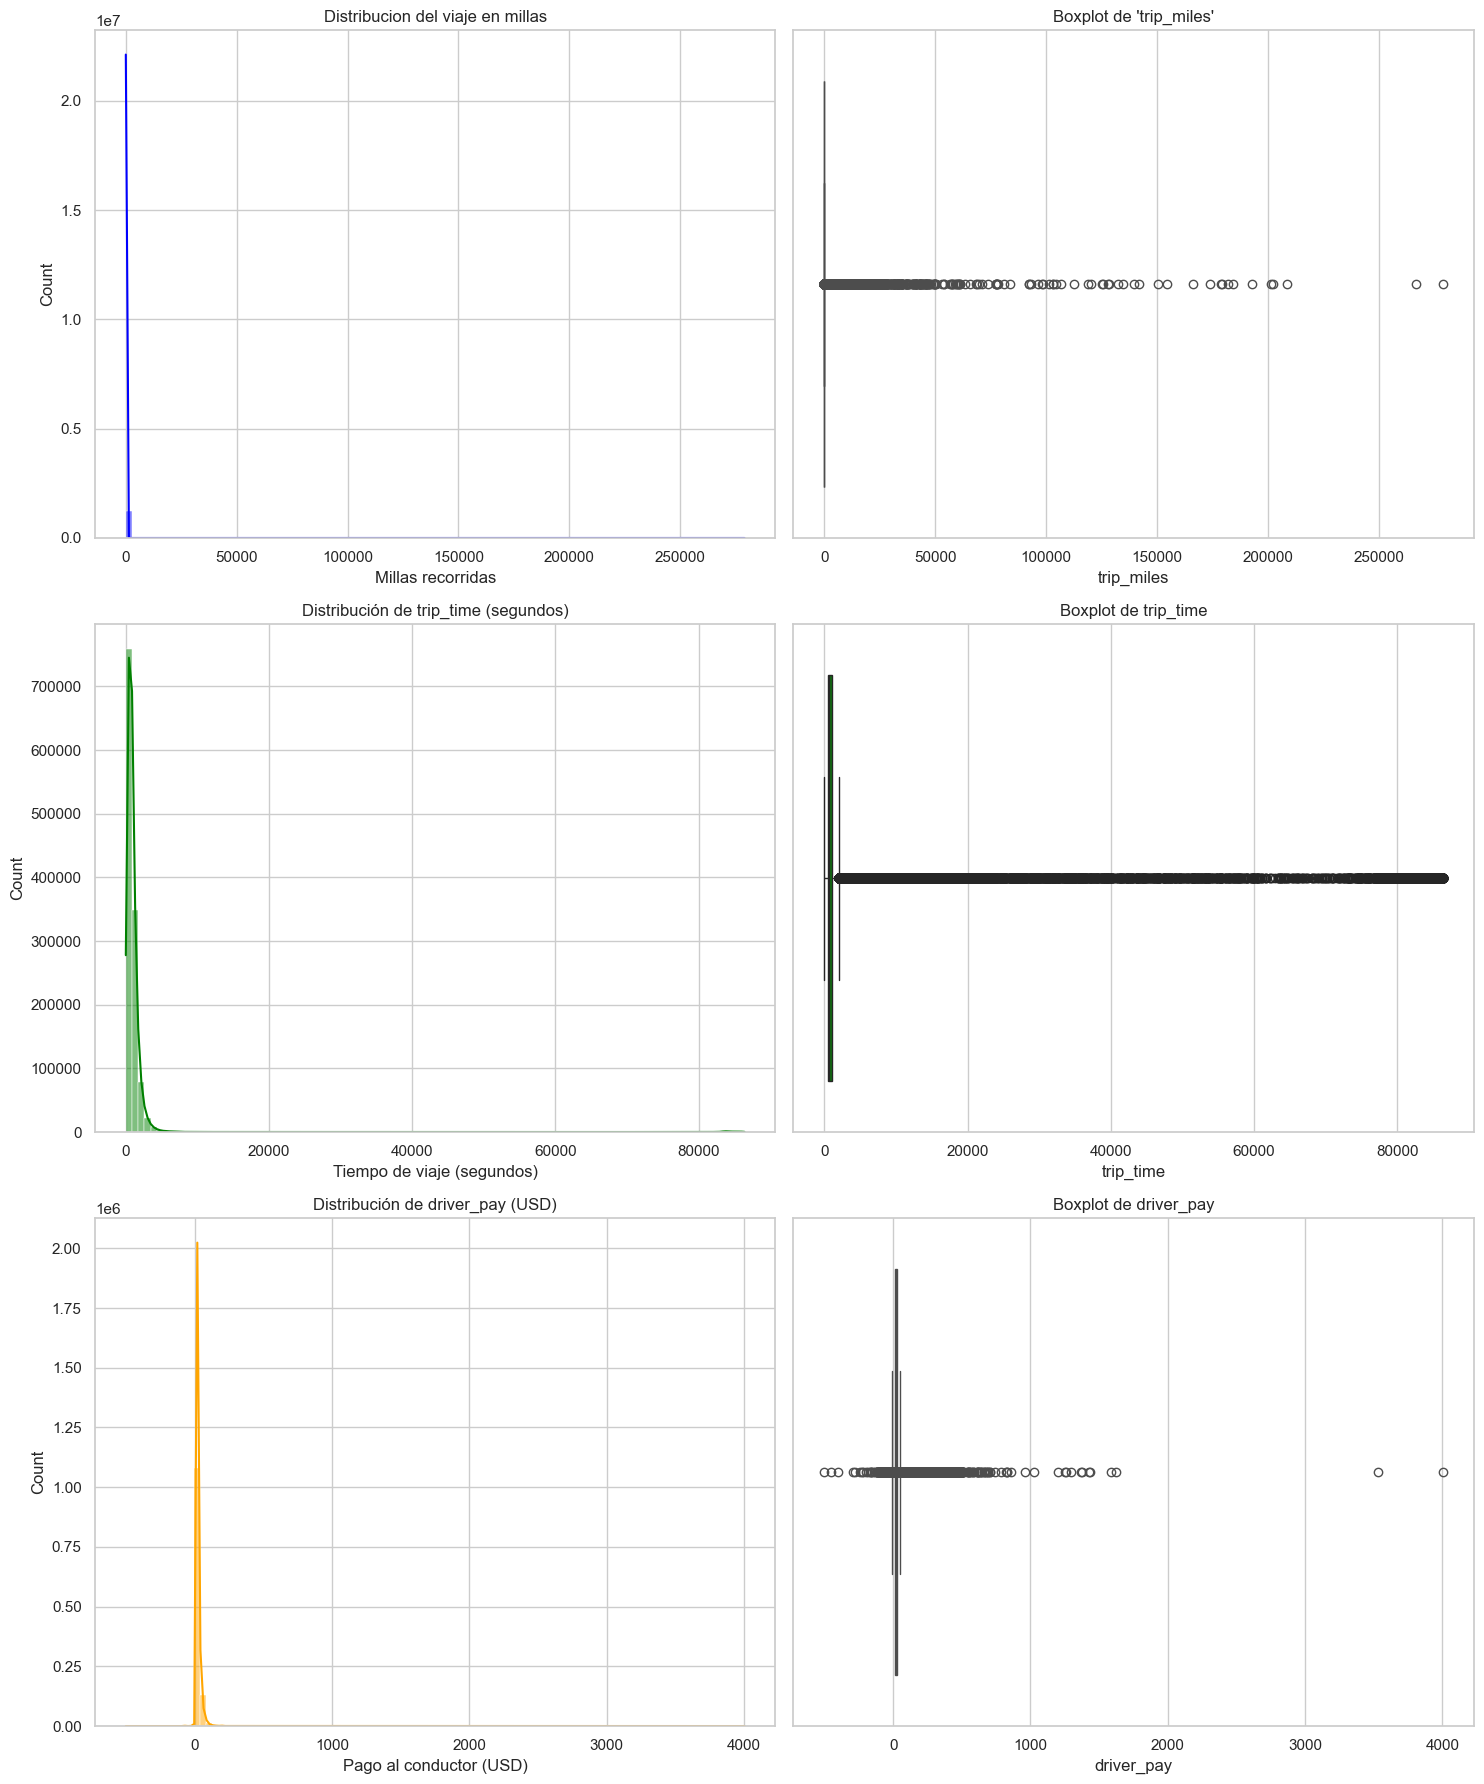

In [ ]:
# Importamos librerias para crear graficos
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

sns.histplot(std_taxis['trip_miles'], bins=100, kde=True, ax=axes[0,0], color='blue')
axes[0, 0].set_title("Distribucion del viaje en millas")
axes[0, 0].set_xlabel("Millas recorridas")

sns.boxplot(x=std_taxis['trip_miles'], ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Boxplot de 'trip_miles'")

# trip_time
sns.histplot(x=std_taxis['trip_time'], bins=100, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title("Distribución de trip_time (segundos)")
axes[1, 0].set_xlabel("Tiempo de viaje (segundos)")

sns.boxplot(x=std_taxis['trip_time'], ax=axes[1, 1], color='green')
axes[1, 1].set_title("Boxplot de 'trip_time'")

# driver_pay
sns.histplot(std_taxis['driver_pay'], bins=100, kde=True, ax=axes[2, 0], color='orange')
axes[2, 0].set_title("Distribución de driver_pay (USD)")
axes[2, 0].set_xlabel("Pago al conductor (USD)")

sns.boxplot(x=std_taxis['driver_pay'], ax=axes[2, 1], color='orange')
axes[2, 1].set_title("Boxplot de driver_pay")

plt.tight_layout()
plt.show()


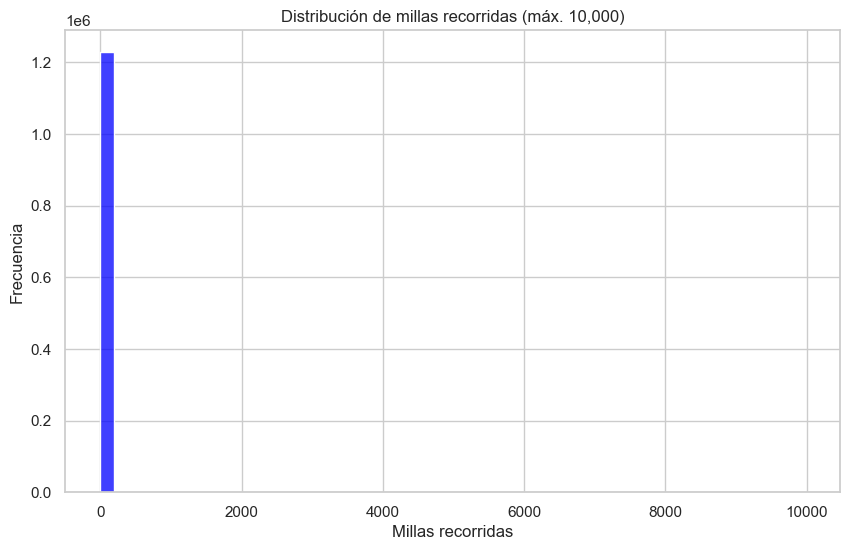

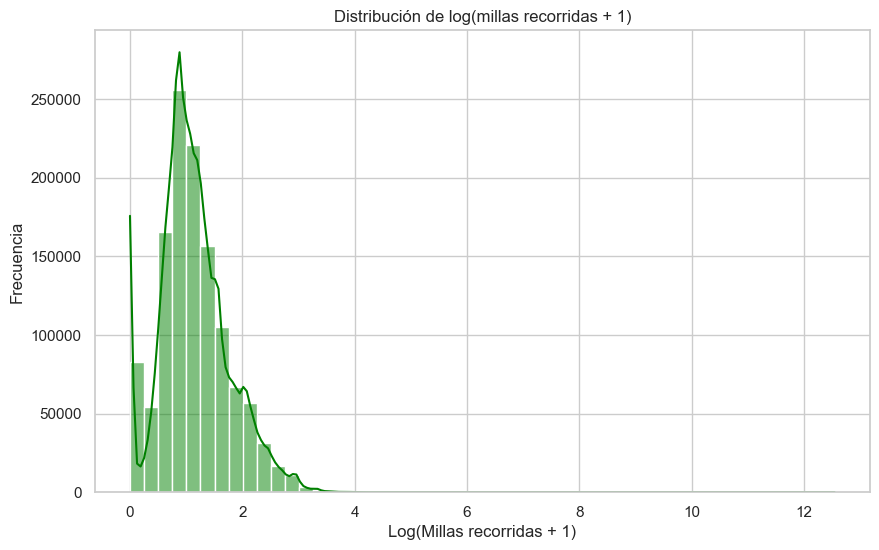

In [ ]:
# Filtrar valores extremos (limitar a un rango menor)
filtered_data = std_taxis[std_taxis['trip_miles'] <= 10000]

# Histograma ajustado sin KDE
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['trip_miles'], bins=50, color='blue')
plt.title("Distribución de millas recorridas (máx. 10,000)")
plt.xlabel("Millas recorridas")
plt.ylabel("Frecuencia")
plt.show()

# Aplicar transformación logarítmica y graficar
log_trip_miles = np.log1p(std_taxis['trip_miles'])  # log(1 + x) para manejar ceros
plt.figure(figsize=(10, 6))
sns.histplot(log_trip_miles, bins=50, kde=True, color='green')
plt.title("Distribución de log(millas recorridas + 1)")
plt.xlabel("Log(Millas recorridas + 1)")
plt.ylabel("Frecuencia")
plt.show()


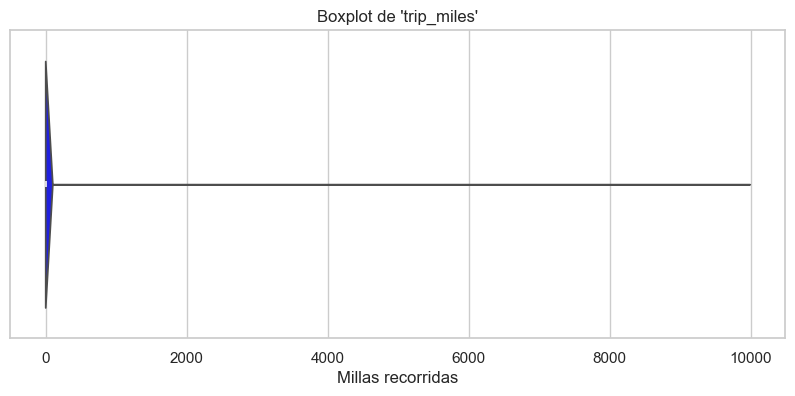

In [64]:
# Boxplot para 'trip_miles'
plt.figure(figsize=(10, 4))
sns.violinplot(x=filtered_data['trip_miles'], color='blue')
plt.title("Boxplot de 'trip_miles'")
plt.xlabel("Millas recorridas")
plt.show()

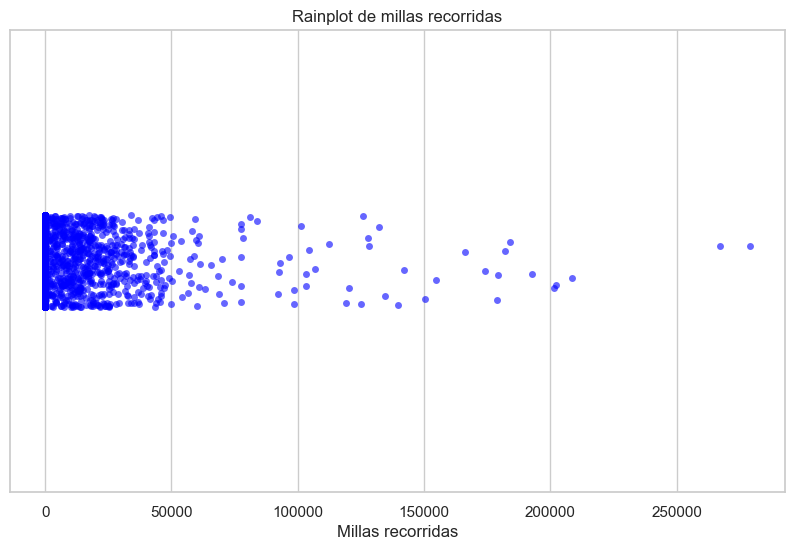

In [ ]:
# Filtrar valores extremos (limitar a un rango menor)
filtered_data = std_taxis[std_taxis['trip_miles'] <= 10000]

# Rainplot (gráfico de lluvia) para trip_miles
plt.figure(figsize=(10, 6))
sns.stripplot(
    x=std_taxis['trip_miles'], 
    jitter=True,  # Jitter para dispersar los puntos
    color='blue', 
    alpha=0.6  # Transparencia para puntos superpuestos
)
plt.title("Rainplot de millas recorridas")
plt.xlabel("Millas recorridas")
plt.show()
